## Stock price prediction based on top 25 news headlines
-------------------------

### About the dataset:
This dataset was downloaded from [Kaggle](https://www.kaggle.com/aaron7sun/stocknews). There are two channels of data provided in this dataset:

* News data: This dataset was collected using historical news headlines from Reddit WorldNews Channel (/r/worldnews). They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. (Range: 2008-06-08 to 2016-07-01)


* Stock data: This dataset was collected from Dow Jones Industrial Average (DJIA) is used to "prove the concept".(Range: 2008-08-08 to 2016-07-01)

Also, a binary class was made for the target variable with "1" being DJIA Adj Close value rose or stayed as the same, and "0" being DJIA Adj Close value decreased.

Our goal is to create a binary classification model that predict the price of DJIA based on the top 25 news headlines of the day.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from collections import Counter
from pandarallel import pandarallel

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler      
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/daolanvi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load and read the "Combined_News_DJIA" dataset
df = pd.read_csv('Combined_News_DJIA.csv')
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [3]:
# Print out variables and column datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1989 non-null   object
 1   Label   1989 non-null   int64 
 2   Top1    1989 non-null   object
 3   Top2    1989 non-null   object
 4   Top3    1989 non-null   object
 5   Top4    1989 non-null   object
 6   Top5    1989 non-null   object
 7   Top6    1989 non-null   object
 8   Top7    1989 non-null   object
 9   Top8    1989 non-null   object
 10  Top9    1989 non-null   object
 11  Top10   1989 non-null   object
 12  Top11   1989 non-null   object
 13  Top12   1989 non-null   object
 14  Top13   1989 non-null   object
 15  Top14   1989 non-null   object
 16  Top15   1989 non-null   object
 17  Top16   1989 non-null   object
 18  Top17   1989 non-null   object
 19  Top18   1989 non-null   object
 20  Top19   1989 non-null   object
 21  Top20   1989 non-null   object
 22  Top21   1989 non-null   

In [4]:
# Inspect target variable
df['Label'].value_counts()

1    1065
0     924
Name: Label, dtype: int64

In [5]:
# Print out an example of new headline
example = df.iloc[3,3]
print(example)

b"When the president ordered to attack Tskhinvali [the capital of South Ossetia], we knew then we were doomed. How come he didn't realize that?"


In [6]:
# Create a "combined_news" column that append all news headlines for each entry and drop top news features
df['combined_news'] = df.filter(regex=('Top.*')).apply(lambda x: ''.join(str(x.values)), axis=1)

df.drop(['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8',
       'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16',
       'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24',
       'Top25', 'Date'], axis=1, inplace=True)

df.head()

,Label,combined_news
0,0,"['b""Georgia \'downs two Russian warplanes\' as..."
1,1,"[""b'Why wont America and Nato help us? If they..."
2,0,"[""b'Remember that adorable 9-year-old who sang..."
3,0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1,"[""b'All the experts admit that we should legal..."


In [7]:
stop = text.ENGLISH_STOP_WORDS

# Basic text cleaning function
def remove_noise(text):
    text = text.str.replace('b\"|b\'|b|\\\\|\\\|\n|', '', regex=True)
    text = text.apply(lambda x: ' '.join(x.lower() for x in x.split())) # transform text to lowercase
    text = text.apply(lambda x: ' '.join(x.strip() for x in x.split())) # remove whitespaces
    text = text.str.replace('[^\w\s]', '') # remove punctuation
    text = text.str.replace('\d+', '') # remove numbers
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # remove stopwords
    text = text.apply(lambda x:' '.join([x for x in x.split() if len(x)>2])) # remove words with less than 2 characters
    text = text.astype(str) # convert to string 
    return text

# Applying noise removal function to data
df['filtered_news'] = remove_noise(df['combined_news'])
df.head()

,Label,combined_news,filtered_news
0,0,"['b""Georgia \'downs two Russian warplanes\' as...",georgia downs russian warplanes countries rink...
1,1,"[""b'Why wont America and Nato help us? If they...",wont america nato help wont help did help iraq...
2,0,"[""b'Remember that adorable 9-year-old who sang...",rememer adorale yearold sang opening ceremonie...
3,0,"[""b' U.S. refuses Israel weapons to attack Ira...",refuses israel weapons attack iran report pres...
4,1,"[""b'All the experts admit that we should legal...",experts admit legalise drugs war south osetia ...


In [8]:
# Example of a combined news headlines before text cleaning
df.iloc[0,-2]

'[\'b"Georgia \\\'downs two Russian warplanes\\\' as countries move to brink of war"\'\n "b\'BREAKING: Musharraf to be impeached.\'"\n "b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\'"\n "b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\'"\n \'b"Afghan children raped with \\\'impunity,\\\' U.N. official says - this is sick, a three year old was raped and they do nothing"\'\n "b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\'"\n \'b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\\\'s side"\'\n \'b"The \\\'enemy combatent\\\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."\'\n "b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDE

In [9]:
# Example of a combined news headlines after text cleaning
df.iloc[0,-1]

'georgia downs russian warplanes countries rink war breaking musharraf impeached russia today columns troops roll south ossetia footage fighting youtue russian tanks moving capital south ossetia reportedly een completely destroyed georgian artillery afghan children raped impunity official says sick year old raped russian tanks entered south ossetia whilst georgia shoots russian jets breaking georgia invades south ossetia russia warned intervene sos enemy comatent trials sham salim haman een sentenced years kept longer just ecause feel like georgian troops retreat osettain capital presumaly leaving people killed video did prep georgia war russia rice gives green light israel attack iran says veto israeli military ops announcingclass action lawsuit behalf american pulic fbi sorussia georgia war nyts story opening ceremonies olympics fucking disgrace proof decline journalism china tells bush stay countries affairs did world war iii start today georgia invades south ossetia russia gets inv

In [10]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatization helper function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmazation function to the filtered news headlines
df['filtered_news'] = df['filtered_news'].apply(lemmatize_text)

# Drop 'combined_news' feature as we won't need this for our model
df.drop('combined_news', axis=1, inplace=True)
df.head()

,Label,filtered_news
0,0,"[georgia, down, russian, warplane, country, ri..."
1,1,"[wont, america, nato, help, wont, help, did, h..."
2,0,"[rememer, adorale, yearold, sang, opening, cer..."
3,0,"[refuse, israel, weapon, attack, iran, report,..."
4,1,"[expert, admit, legalise, drug, war, south, os..."


In [11]:
# Create 2 different recommended and not_recommended dataframe:
djia_up_words = df[df['Label']==1]
djia_down_words = df[df['Label']==0]

words_djia_up = djia_up_words['filtered_news'].tolist()
words_djia_down = djia_down_words['filtered_news'].tolist()

djia_up_list = []
for sublist in words_djia_up:
    for words in sublist:
        djia_up_list.append(words)

djia_down_list = []
for sublist in words_djia_down:
    for words in sublist:
        djia_down_list.append(words)
        
print('DJIA up list count : {}'.format(len(djia_up_list)))
print('DJIA down list count : {}'.format(len(djia_down_list)))        

DJIA up list count : 288912
DJIA down list count : 251052


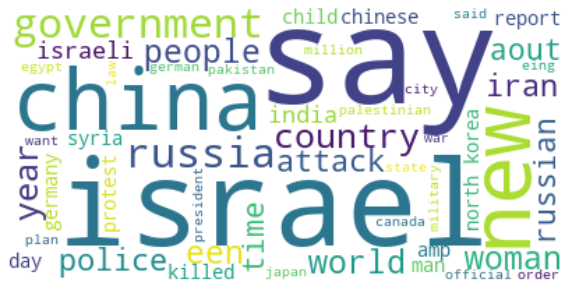

In [12]:
# Create wordcloud of top 50 words that has target variable = 1
wordcloud = WordCloud(background_color="white", max_words=50).generate(' '.join(djia_up_list))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

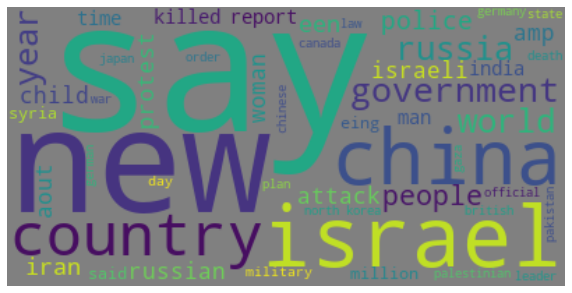

In [13]:
# Create wordcloud of top 50 words that has target variable = 0
wordcloud = WordCloud(background_color="grey", max_words=50).generate(' '.join(djia_down_list))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

### Countvectorizer method:

In [14]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - meaning either single or two word combination will be extracted
cvec = CountVectorizer(min_df=.05, max_df=.7, ngram_range=(1,2), tokenizer=lambda doc:doc, lowercase=False)
cvec_counts = cvec.fit_transform(df['filtered_news'])
print('sparse matrix shape:', cvec_counts.shape)

sparse matrix shape: (1989, 1011)


In [15]:
vocabs = cvec.get_feature_names()

In [16]:
# Dataframe using countvectorizer:
cvec_df = pd.DataFrame(cvec_counts.todense(),columns = vocabs) 
cvec_df = pd.merge(cvec_df, df[['Label']], left_index=True, right_index=True)
print(cvec_df.shape)
cvec_df.head()

(1989, 1012)


,access,according,account,accused,accuses,ack,act,action,activist,activity,...,year ago,year old,year prison,yearold,yemen,young,youth,zealand,zone,Label
0,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,2,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
# Separate target variable and explanatory variables
X = cvec_df.iloc[:,:-1]
y = cvec_df['Label']
print(X.shape, y.shape)

# Split the dataset into testing and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1989, 1011) (1989,)
(1591, 1011) (1591,)
(398, 1011) (398,)


In [18]:
# Helper function to execute the model and calculate accuracy score
def model_execute(mod, model_name, X_train, y_train, X_test, y_test):
    %timeit mod.fit(X_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    print('')
    print('Accuracy on train set is {}'.format(acc.mean()))
    print('Accuracy on test set is {}'.format(accuracy_score(y_test, mod.predict(X_test))))
    print('F1 score is {}'.format(metrics.f1_score(y_test, mod.predict(X_test))))
    print('Precision score is {}'.format(metrics.precision_score(y_test, mod.predict(X_test))))
    print('Recall score is {}'.format(metrics.recall_score(y_test, mod.predict(X_test))))
    cm = confusion_matrix(mod.predict(X_test),y_test)
    print("Confusion Matrix:  \n", cm)

In [19]:
# Gaussian model
gnb = GaussianNB()
model_execute(gnb, "Gaussian Naive Bayes", X_train, y_train, X_test, y_test)

26.8 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Gaussian Naive Bayes

Accuracy on train set is 0.5040969223792906
Accuracy on test set is 0.5201005025125628
F1 score is 0.5688487584650112
Precision score is 0.5478260869565217
Recall score is 0.5915492957746479
Confusion Matrix:  
 [[ 81  87]
 [104 126]]


In [20]:
# Random forest classifier
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=1234)
model_execute(rfc, "Random Forest Classifier", X_train, y_train, X_test, y_test)

1.52 s ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Random Forest Classifier

Accuracy on train set is 0.5097494134579366
Accuracy on test set is 0.5276381909547738
F1 score is 0.6356589147286822
Precision score is 0.5412541254125413
Recall score is 0.7699530516431925
Confusion Matrix:  
 [[ 46  49]
 [139 164]]


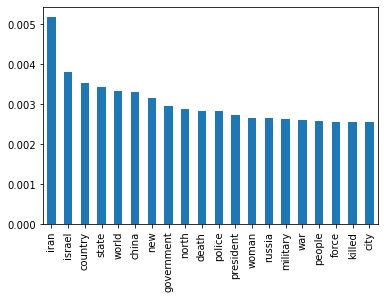

In [21]:
important_features = pd.Series(data=rfc.feature_importances_, index=X_train.columns)
important_features.sort_values(ascending=False).head(20).plot(kind='bar')

In [22]:
# Support vector machine
svm = SVC(probability=True, kernel='rbf')
model_execute(svm, "Support Vector Classifier", X_train, y_train, X_test, y_test)

15.8 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Support Vector Classifier

Accuracy on train set is 0.5028292028942647
Accuracy on test set is 0.5226130653266332
F1 score is 0.6317829457364341
Precision score is 0.5379537953795379
Recall score is 0.7652582159624414
Confusion Matrix:  
 [[ 45  50]
 [140 163]]


In [23]:
# Xgboost 
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create xgboost classifier model:
model = xgb.XGBClassifier()

scorings = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss':'neg_log_loss'}
params = {
        'learning_rate': [0.1, 0.01, 0.02],
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth':[3, 4, 5],
        'colsample_bytree': [0.3, 0.6, 0.8],
        'min_child_weight': [1, 3, 5],
        }

#Cross validation to find the best parameters:
clf = RandomizedSearchCV(model, params, cv=5, scoring=scorings, refit='AUC', return_train_score=True)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [24]:
# Print out the best parameters for our xgb model:
print((clf.best_score_, clf.best_params_))
print('-'*30)

print('Grid scores on training data:')
means = clf.cv_results_['mean_test_AUC']
stds = clf.cv_results_['std_test_AUC']
log_losses = clf.cv_results_['std_test_Loss']

for mean, std, log_loss, params in zip(means, stds, log_losses, clf.cv_results_['params']):
    print('AUC Score: %0.3f (+/-%0.03f); Log Loss: %0.3f for %r' % (mean, std * 2, log_loss, params))

(0.5028441571033344, {'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8})
------------------------------
Grid scores on training data:
AUC Score: 0.499 (+/-0.034); Log Loss: 0.020 for {'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
AUC Score: 0.502 (+/-0.060); Log Loss: 0.029 for {'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
AUC Score: 0.495 (+/-0.064); Log Loss: 0.017 for {'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
AUC Score: 0.490 (+/-0.049); Log Loss: 0.022 for {'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
AUC Score: 0.486 (+/-0.062); Log Loss: 0.029 for {'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
AUC Score: 0.491 (+/-0.

### TFIDF method:

In [25]:
# Using tfidf:
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10155138,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09403604, 0.08045539, 0.        , ..., 0.        , 0.09403604,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06550046, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
# Getting a list of all n-grams
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
tfidf_model = pd.DataFrame(transformed_weights.todense(), columns=vocab)
tfidf_df = pd.merge(tfidf_model, df[['Label']], left_index=True, right_index=True)
print(tfidf_df.shape)
tfidf_df.head()

(1989, 1012)


,access,according,account,accused,accuses,ack,act,action,activist,activity,...,year ago,year old,year prison,yearold,yemen,young,youth,zealand,zone,Label
0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.082085,0.076039,0.0,0.000000,...,0.0,0.083412,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0
1,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.101551,0.0,1
2,0.0,0.0,0.0,0.0,0.10802,0.000000,0.000000,0.000000,0.0,0.110029,...,0.0,0.000000,0.0,0.152363,0.0,0.0,0.0,0.000000,0.0,0
3,0.0,0.0,0.0,0.0,0.10860,0.000000,0.000000,0.084203,0.0,0.000000,...,0.0,0.092369,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0
4,0.0,0.0,0.0,0.0,0.00000,0.078958,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1


In [27]:
# Separate target variable and explatory variables
X_tf = tfidf_df.iloc[:,:-1]
y_tf = tfidf_df['Label']
print(X.shape, y.shape)

# Scale the dataset
scaler= StandardScaler()
X_tf = scaler.fit_transform(X_tf)

# Train_test_split
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.2, random_state=123)
print(X_train_tf.shape, y_train_tf.shape)
print(X_test_tf.shape, y_test_tf.shape)

(1989, 1011) (1989,)
(1591, 1011) (1591,)
(398, 1011) (398,)


In [28]:
# Helper function
def model_execute_tf(mod, model_name, X_train_tf, y_train_tf, X_test_tf, y_test_tf):
    %timeit mod.fit(X_train_tf, y_train_tf)
    print(model_name)
    acc = cross_val_score(mod, X_train_tf, y_train_tf, scoring = "accuracy", cv = 5)
    print('')
    print('Accuracy on train set is {}'.format(acc.mean()))
    print('Accuracy on test set is {}'.format(accuracy_score(y_test_tf, mod.predict(X_test_tf))))
    print('F1 score is {}'.format(metrics.f1_score(y_test_tf, mod.predict(X_test_tf))))
    print('Precision score is {}'.format(metrics.precision_score(y_test_tf, mod.predict(X_test_tf))))
    print('Recall score is {}'.format(metrics.recall_score(y_test_tf, mod.predict(X_test_tf))))
    cm = confusion_matrix(mod.predict(X_test_tf),y_test_tf)
    print("Confusion Matrix:  \n", cm)

In [29]:
# Gaussian model
gnb = GaussianNB()
model_execute(gnb, "Gaussian Naive Bayes", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

22.1 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Gaussian Naive Bayes

Accuracy on train set is 0.5041067802290964
Accuracy on test set is 0.5402010050251256
F1 score is 0.5793103448275861
Precision score is 0.5675675675675675
Recall score is 0.5915492957746479
Confusion Matrix:  
 [[ 89  87]
 [ 96 126]]


In [30]:
# Random forest classifier
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=1234)
model_execute(rfc, "Random Forest Classifier", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

3.2 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Random Forest Classifier

Accuracy on train set is 0.49969637822598134
Accuracy on test set is 0.535175879396985
F1 score is 0.6277665995975855
Precision score is 0.5492957746478874
Recall score is 0.7323943661971831
Confusion Matrix:  
 [[ 57  57]
 [128 156]]


In [31]:
# Support vector machine
svm = SVC(probability=True, kernel='rbf')
model_execute(svm, "Support Vector Classifier", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

15.8 s ± 9.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Support Vector Classifier

Accuracy on train set is 0.5053370398848605
Accuracy on test set is 0.5025125628140703
F1 score is 0.6192307692307693
Precision score is 0.5244299674267101
Recall score is 0.755868544600939
Confusion Matrix:  
 [[ 39  52]
 [146 161]]


In [32]:
# Xgboost 
data_dmatrix = xgb.DMatrix(data=X_tf,label=y_tf)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.2, random_state=123)

# Create xgboost classifier model:
model = xgb.XGBClassifier()

scorings = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss':'neg_log_loss'}
params = {
        'learning_rate': [0.1, 0.01, 0.02],
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth':[3, 4, 5],
        'colsample_bytree': [0.3, 0.6, 0.8],
        'min_child_weight': [1, 3, 5],
        }

#Cross validation to find the best parameters:
clf = RandomizedSearchCV(model, params, cv=5, scoring=scorings, refit='AUC', return_train_score=True)
clf.fit(X_train_tf, y_train_tf)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [33]:
# Print out the best parameters for our xgb model:
print((clf.best_score_, clf.best_params_))
print('-'*30)

print('Grid scores on training data:')
means = clf.cv_results_['mean_test_AUC']
stds = clf.cv_results_['std_test_AUC']
log_losses = clf.cv_results_['std_test_Loss']

for mean, std, log_loss, params in zip(means, stds, log_losses, clf.cv_results_['params']):
    print('AUC Score: %0.3f (+/-%0.03f); Log Loss: %0.3f for %r' % (mean, std * 2, log_loss, params))

(0.4984610104512802, {'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.8})
------------------------------
Grid scores on training data:
AUC Score: 0.492 (+/-0.043); Log Loss: 0.018 for {'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
AUC Score: 0.484 (+/-0.028); Log Loss: 0.004 for {'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
AUC Score: 0.494 (+/-0.064); Log Loss: 0.024 for {'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
AUC Score: 0.488 (+/-0.054); Log Loss: 0.013 for {'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
AUC Score: 0.484 (+/-0.041); Log Loss: 0.014 for {'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
AUC Score: 0.498 (+/-0